<h2 style="color:purple">Import libraries</h3>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

<h2 style="color:purple">Load the CSV's</h3>

In [2]:
train_df = pd.read_csv("/kaggle/input/train-test-metadata/train_data.csv")
val_df = pd.read_csv("/kaggle/input/train-test-metadata/validation_data.csv")
test_df = pd.read_csv("/kaggle/input/train-test-metadata/test_data.csv")

In [4]:
train_df.head()

,filename,actor,gender,emotion,emotion_code,duration,loudness,voice_ratio,centroid_mean,centroid_std,...,mfcc_13,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,tonnetz_2,tonnetz_4,pitch_mean
0,03-01-03-01-01-01-05.wav,5,female,happy,3,1.984,-14.873622,0.951613,3190.964220,1122.462784,...,-6.982915,25.503151,17.708561,18.943537,19.238564,18.832926,20.539578,-0.003049,-0.009414,2145.6292
1,03-01-03-01-01-01-05.wav_stretch,5,female,happy,3,2.480,-13.317622,0.967742,3238.474140,1170.150289,...,-6.366129,26.081604,17.631333,20.689296,21.072364,19.998867,21.690806,0.015322,-0.022258,2136.1710
2,03-01-03-01-01-01-05.wav_shift,5,female,happy,3,1.984,-13.674015,0.967742,3377.553612,1165.026115,...,-13.436652,24.805513,19.148285,19.877902,19.766768,20.623882,21.950159,0.013038,0.010972,2236.9731
3,03-01-06-01-02-01-05.wav,5,female,fearful,6,1.248,-13.484844,0.974359,2967.909275,1026.945824,...,-13.448425,25.327035,16.153436,17.501388,19.844352,16.381218,17.972317,-0.017012,-0.011851,2106.0857
4,03-01-06-01-02-01-05.wav_stretch,5,female,fearful,6,1.560,-12.717693,0.984615,3050.661744,1036.944592,...,-12.969749,25.262106,17.243222,19.647477,20.480816,17.853545,19.661650,-0.026152,-0.011460,2066.7065


<h3 style="color:purple">Drop unwanted columns</h3>

In [5]:
drop_col = ['actor', 'filename', 'gender', 'emotion_code']
train_df = train_df.drop(columns=drop_col)
val_df = val_df.drop(columns=drop_col)
test_df = test_df.drop(columns=drop_col)

In [6]:
len(train_df.columns)

41

<h2 style="color:purple">Separate feature and labels</h3>

In [7]:
X_train = train_df.drop('emotion', axis=1)
y_train = train_df['emotion']

X_val = val_df.drop('emotion', axis=1)
y_val = val_df['emotion']

X_test = test_df.drop('emotion', axis=1)
y_test = test_df['emotion']


In [18]:
print("Training Data Shape: ", X_train.shape)
y_train.value_counts(normalize=True)

Training Data Shape:  (3072, 40)


emotion
neutral      0.125
happy        0.125
disgust      0.125
sad          0.125
calm         0.125
angry        0.125
surprised    0.125
fearful      0.125
Name: proportion, dtype: float64

In [16]:
import pandas as pd
from sklearn.utils import resample

# Combine X and y into one DataFrame for easier manipulation
df = pd.concat([X_train, y_train], axis=1)

# Separate majority and minority class
df_majority = df[df['emotion'] != 'neutral']
df_minority = df[df['emotion'] == 'neutral']

# Upsample minority class
df_minority_upsampled = resample(
    df_minority,
    replace=True,               # Sample with replacement
    n_samples=len(df_majority) // 7,  # Match size of each majority class
    random_state=42
)

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Split back to X and y
X_train = df_balanced.drop("emotion", axis=1)
y_train = df_balanced["emotion"]


In [17]:
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print(class_weights)

{'angry': 1.0, 'calm': 1.0, 'disgust': 1.0, 'fearful': 1.0, 'happy': 1.0, 'neutral': 1.0, 'sad': 1.0, 'surprised': 1.0}


<h2 style="color:purple">Model Building: Logistic Regression</h3>

In [19]:
from sklearn.linear_model import LogisticRegression

In [20]:
lr = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    multi_class='multinomial',
    max_iter=1000,
    random_state=42)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42)

In [21]:
lr.score(X_train, y_train)*100, lr.score(X_val, y_val)*100

(50.358072916666664, 37.083333333333336)

In [22]:
# predict validation data
y_pred_lr = lr.predict(X_val)

In [23]:
print("Accuracy Score: ", accuracy_score(y_val, y_pred_lr))
print("Classification Report: \n", classification_report(y_val, y_pred_lr))

Accuracy Score:  0.37083333333333335
Classification Report: 
               precision    recall  f1-score   support

       angry       0.33      0.48      0.39        96
        calm       0.40      0.45      0.42        96
     disgust       0.56      0.51      0.53        96
     fearful       0.34      0.32      0.33        96
       happy       0.42      0.35      0.38        96
     neutral       0.19      0.35      0.25        48
         sad       0.50      0.05      0.09        96
   surprised       0.37      0.44      0.40        96

    accuracy                           0.37       720
   macro avg       0.39      0.37      0.35       720
weighted avg       0.40      0.37      0.36       720



In [24]:
train_df['emotion'].unique()

array(['happy', 'fearful', 'disgust', 'surprised', 'sad', 'angry', 'calm',
       'neutral'], dtype=object)

In [29]:
var = y_train
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit_transform(var)

array([5, 4, 4, ..., 6, 2, 1])

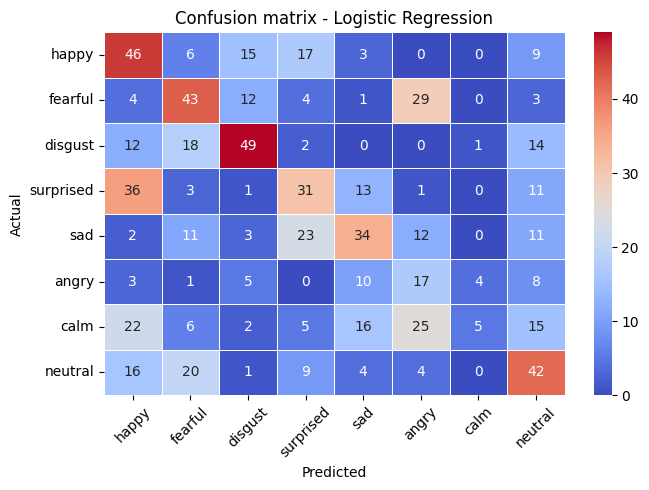

In [30]:
# plot confusion matrix
cm = confusion_matrix(y_val, y_pred_lr)

emotion_labels = ['happy', 'fearful', 'disgust', 'surprised', 'sad', 'angry', 'calm','neutral']
plt.figure(figsize=(7, 5))
sns.heatmap(cm, fmt='d', cmap='coolwarm', annot=True, linewidths=0.5, xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.title('Confusion matrix - Logistic Regression')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h2 style="color:purple">Random Forest</h3>

In [31]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=42,
                             max_depth=None,
                             n_estimators=100)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
rf.score(X_train, y_train)*100, rf.score(X_val, y_val)*100

(100.0, 48.05555555555556)

In [86]:
# predict validation data
y_pred_rf = rf.predict(X_val)

In [34]:
print("Accuracy Score: ", accuracy_score(y_val, y_pred_rf))
print("Classification Report: \n", classification_report(y_val, y_pred_rf))

Accuracy Score:  0.48055555555555557
Classification Report: 
               precision    recall  f1-score   support

       angry       0.61      0.54      0.57        96
        calm       0.38      0.78      0.51        96
     disgust       0.73      0.55      0.63        96
     fearful       0.51      0.47      0.49        96
       happy       0.48      0.41      0.44        96
     neutral       0.52      0.46      0.49        48
         sad       0.27      0.16      0.20        96
   surprised       0.47      0.47      0.47        96

    accuracy                           0.48       720
   macro avg       0.50      0.48      0.47       720
weighted avg       0.49      0.48      0.47       720



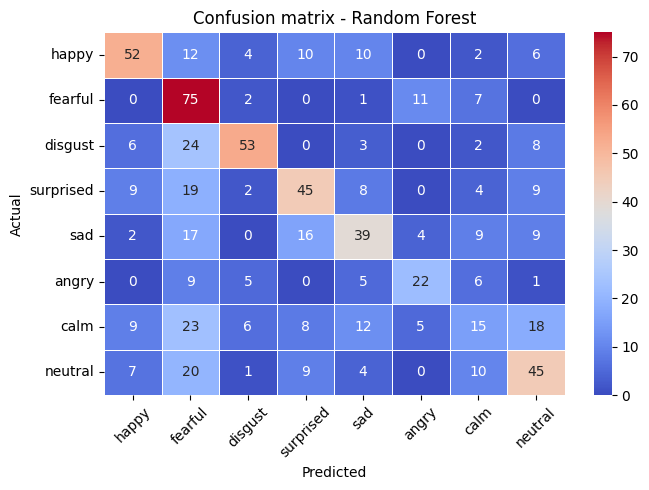

In [35]:
# plot confusion matrix
cm = confusion_matrix(y_val, y_pred_rf)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, fmt='d', cmap='coolwarm', annot=True, linewidths=0.5, xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.title('Confusion matrix - Random Forest')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h2 style="color:purple">k-NN with Elbow Method</h3>

In [36]:
from sklearn.neighbors import KNeighborsClassifier

In [37]:
#elbow method to find k
error_rates = []
k_range = range(1, 31)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_val)
    errors = 1 - accuracy_score(y_val, y_pred_knn)
    error_rates.append(errors)

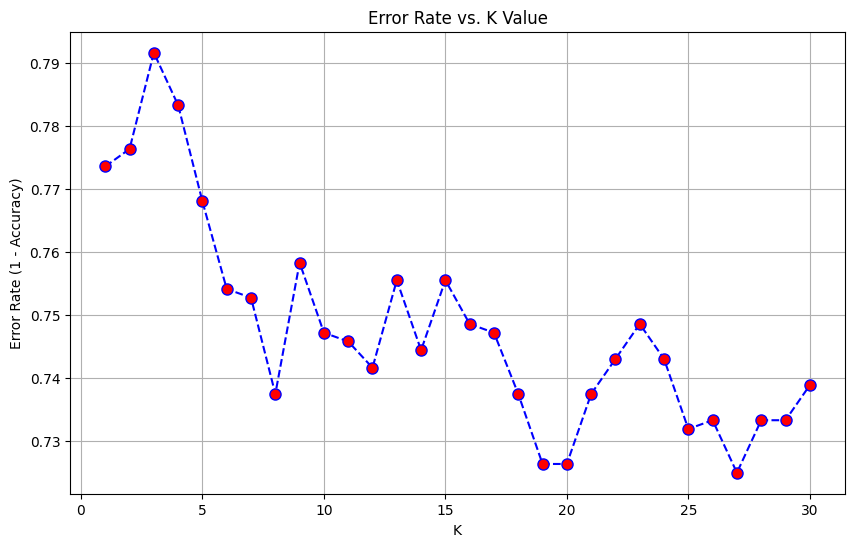

In [38]:
# elbow curve

plt.figure(figsize=(10, 6))
plt.plot(k_range, error_rates, color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=8)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate (1 - Accuracy)')
plt.grid(True)
plt.show()

In [39]:
best_k = error_rates.index(min(error_rates)) + 1  # Add 1 because index starts at 0
print(f"Best k found: {best_k}")

knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)

Best k found: 27


KNeighborsClassifier(n_neighbors=27)

In [40]:
knn_final.score(X_train, y_train)*100, knn_final.score(X_val, y_val)*100

(46.74479166666667, 27.500000000000004)

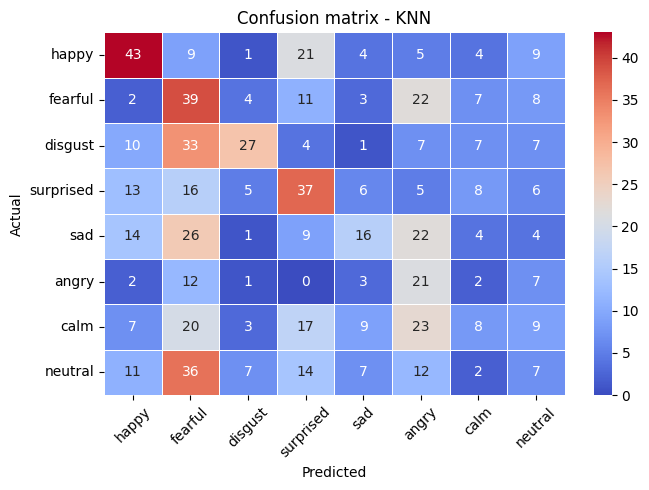

In [41]:
# plot confusion matrix
cm = confusion_matrix(y_val, knn_final.predict(X_val))

plt.figure(figsize=(7, 5))
sns.heatmap(cm, fmt='d', cmap='coolwarm', annot=True, linewidths=0.5, xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.title('Confusion matrix - KNN')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h2 style="color:purple">SVM: SVC</h3>

In [42]:
from sklearn.svm import SVC

In [43]:
svm = SVC(kernel='linear', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [44]:
svm.score(X_train, y_train)*100, svm.score(X_val, y_val)*100

(68.13151041666666, 47.22222222222222)

In [45]:
y_pred_svm = svm.predict(X_val)

In [46]:
print("Accuracy:", accuracy_score(y_val, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_val, y_pred_svm))

Accuracy: 0.4722222222222222

Classification Report:
               precision    recall  f1-score   support

       angry       0.50      0.52      0.51        96
        calm       0.51      0.71      0.59        96
     disgust       0.71      0.64      0.67        96
     fearful       0.46      0.54      0.50        96
       happy       0.39      0.44      0.41        96
     neutral       0.36      0.44      0.40        48
         sad       0.33      0.08      0.13        96
   surprised       0.39      0.40      0.39        96

    accuracy                           0.47       720
   macro avg       0.46      0.47      0.45       720
weighted avg       0.46      0.47      0.45       720



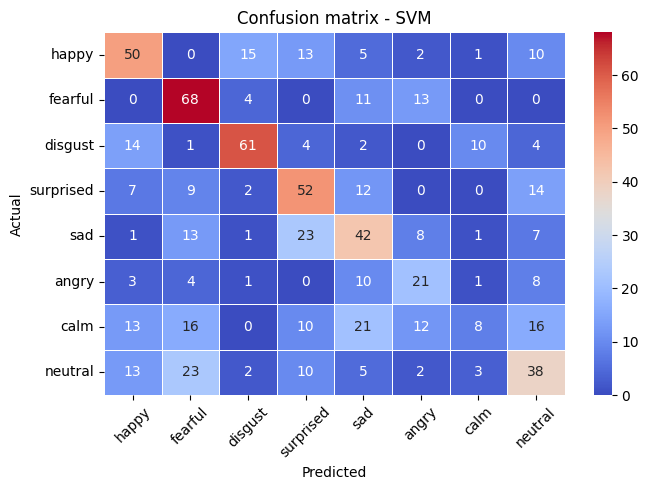

In [47]:
# plot confusion matrix
cm = confusion_matrix(y_val, y_pred_svm)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, fmt='d', cmap='coolwarm', annot=True, linewidths=0.5, xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.title('Confusion matrix - SVM')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h2 style="color:purple">XGBoost</h3>

In [48]:
from xgboost import XGBClassifier

In [51]:
# encode emotion labels before training
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

label_encoder.fit(y_train.tolist() + y_val.tolist() + y_test.tolist())
y_train_enc = label_encoder.transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [52]:

xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=8,  # Number of emotion classes
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train, y_train_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_class=8, num_parallel_tree=None, ...)

In [53]:
xgb.score(X_train, y_train_enc)*100, xgb.score(X_val, y_val_enc)*100

(100.0, 52.22222222222223)

In [54]:
# predict function
y_pred = xgb.predict(X_val)

# decode prediction back to original label
y_pred_xgb = label_encoder.inverse_transform(y_pred)

In [55]:
print("Accuracy:", accuracy_score(y_val, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_val, y_pred_xgb))

Accuracy: 0.5222222222222223

Classification Report:
               precision    recall  f1-score   support

       angry       0.63      0.56      0.59        96
        calm       0.41      0.62      0.50        96
     disgust       0.82      0.71      0.76        96
     fearful       0.45      0.55      0.50        96
       happy       0.46      0.51      0.48        96
     neutral       0.42      0.46      0.44        48
         sad       0.47      0.29      0.36        96
   surprised       0.61      0.44      0.51        96

    accuracy                           0.52       720
   macro avg       0.53      0.52      0.52       720
weighted avg       0.54      0.52      0.52       720



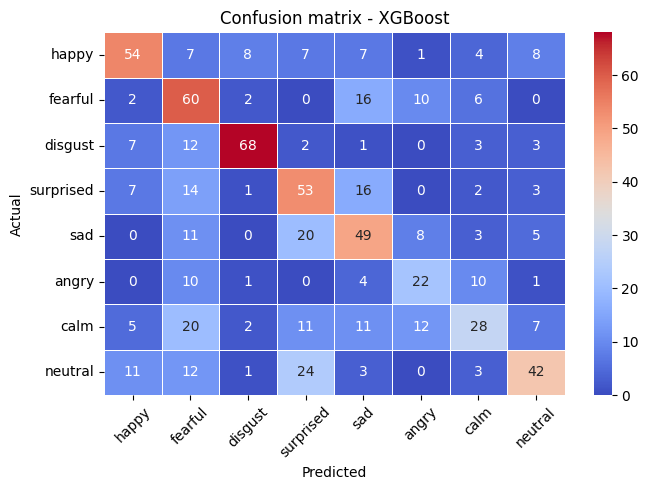

In [56]:
# plot confusion matrix
cm = confusion_matrix(y_val, y_pred_xgb)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, fmt='d', cmap='coolwarm', annot=True, linewidths=0.5, xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.title('Confusion matrix - XGBoost')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h2 style="color:purple">Leaderboard: RandomForest / SVM / XGBoost</h3>

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [58]:
# for random forest
accuracy_rf = accuracy_score(y_val, y_pred_rf)
precision_rf = precision_score(y_val, y_pred_rf, average='weighted')
recall_rf = recall_score(y_val, y_pred_rf, average='weighted')
f1_rf = f1_score(y_val, y_pred_rf, average='weighted')

In [59]:
# for Support Vector Classifier
accuracy_svm = accuracy_score(y_val, y_pred_svm)
precision_svm = precision_score(y_val, y_pred_svm, average='weighted')
recall_svm = recall_score(y_val, y_pred_svm, average='weighted')
f1_svm = f1_score(y_val, y_pred_svm, average='weighted')

In [60]:
# for XGB Classifier
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
precision_xgb = precision_score(y_val, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_val, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_val, y_pred_xgb, average='weighted')

In [61]:
leaderboard = pd.DataFrame([
    {"Model": "Random Forest", "Accuracy": accuracy_rf, "Precision": precision_rf, "Recall": recall_rf, "F1-Score": f1_rf},
    {"Model": "SVM (RBF)", "Accuracy": accuracy_svm, "Precision": precision_svm, "Recall": recall_svm, "F1-Score": f1_svm},
    {"Model": "XGBoost", "Accuracy": accuracy_xgb, "Precision": precision_xgb, "Recall": recall_xgb, "F1-Score": f1_xgb},
])

# Sort by F1-Score descending
leaderboard = leaderboard.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

# Display leaderboard
print(leaderboard)


           Model  Accuracy  Precision    Recall  F1-Score
0        XGBoost  0.522222   0.541320  0.522222  0.522355
1  Random Forest  0.480556   0.494004  0.480556  0.473264
2      SVM (RBF)  0.472222   0.462815  0.472222  0.454166


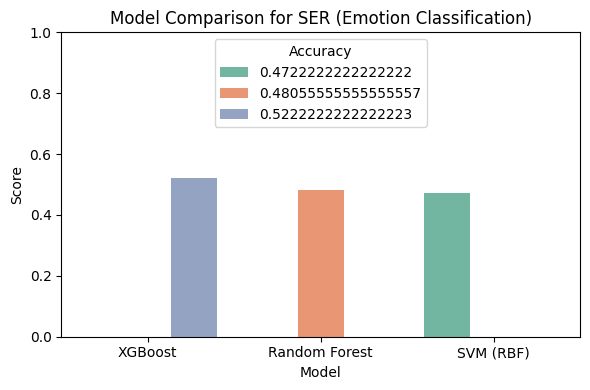

In [63]:
# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=leaderboard, x='Model', y='Accuracy', hue='Accuracy', palette='Set2')

plt.title("Model Comparison for SER (Emotion Classification)")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.legend(title="Accuracy")
plt.tight_layout()
plt.show()

<h2 style="color:purple">Hyperparameter Tuning</h3>

<h3 style="color:purple">Random Forest</h3>

In [64]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, 
                       cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
rf_grid.fit(X_train, y_train)

print("Best RF Params:", rf_grid.best_params_)
print("Best RF Accuracy:", rf_grid.best_score_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best RF Params: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RF Accuracy: 0.8401689573898997


<h3 style="color:purple">SVM</h3>

In [65]:
from sklearn.svm import SVC

svm_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['linear']
}

svm_grid = GridSearchCV(SVC(), svm_params, 
                        cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
svm_grid.fit(X_train, y_train)

print("Best SVM Params:", svm_grid.best_params_)
print("Best SVM Accuracy:", svm_grid.best_score_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best SVM Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best SVM Accuracy: 0.6396499033394243


<h3 style="color:purple">XGBoost</h3>

In [66]:
from xgboost import XGBClassifier

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
                        xgb_params, cv=5, n_jobs=-1, scoring='accuracy', verbose=1)
xgb_grid.fit(X_train, y_train_enc)

print("Best XGB Params:", xgb_grid.best_params_)
print("Best XGB Accuracy:", xgb_grid.best_score_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best XGB Params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}
Best XGB Accuracy: 0.8541654087550647


<h2 style="color:purple">Leaderboard: Tuned Model</h3>

In [67]:
from sklearn.metrics import accuracy_score

# Predict using best estimators
rf_best = rf_grid.best_estimator_
svm_best = svm_grid.best_estimator_
xgb_best = xgb_grid.best_estimator_

In [68]:
rf_acc = accuracy_score(y_val, rf_best.predict(X_val))
svm_acc = accuracy_score(y_val, svm_best.predict(X_val))

xgb_pred = xgb_best.predict(X_val)
xgb_acc_enc = lr.inverse_transform(xgb_pred)
xgb_acc = accuracy_score(y_val, xgb_acc_enc)

In [69]:
# Leaderboard
leaderboard = {
    'Random Forest': rf_acc,
    'SVM (RBF)': svm_acc,
    'XGBoost': xgb_acc
}

# Display leaderboard
import pandas as pd
leaderboard_df = pd.DataFrame(list(leaderboard.items()), columns=['Model', 'Accuracy'])
leaderboard_df = leaderboard_df.sort_values(by='Accuracy', ascending=False)
print(leaderboard_df)

           Model  Accuracy
2        XGBoost  0.515278
0  Random Forest  0.483333
1      SVM (RBF)  0.454167


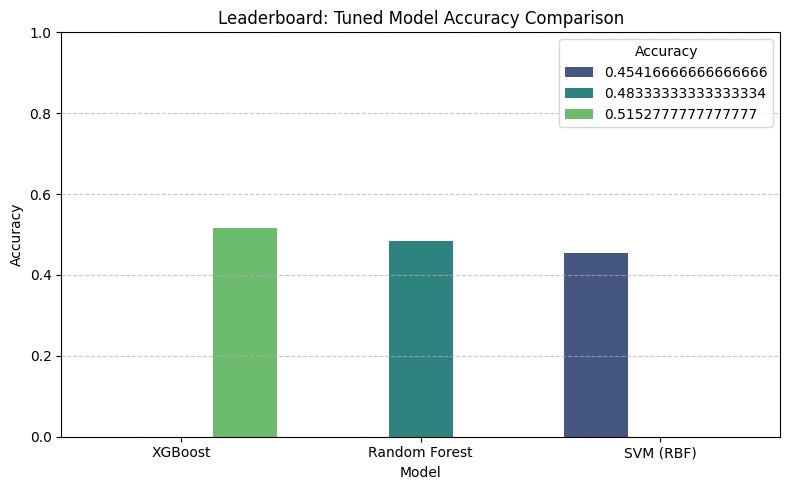

In [70]:
# Plot

plt.figure(figsize=(8, 5))
sns.barplot(data=leaderboard_df, x='Model', y='Accuracy', hue='Accuracy', palette='viridis')
plt.title('Leaderboard: Tuned Model Accuracy Comparison')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<h2 style="color:purple">VotingClassifier: Combine 3 best models</h2>

In [71]:
from sklearn.ensemble import VotingClassifier

# Use the best models 
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_grid.best_estimator_),
        ('svm', svm_grid.best_estimator_),
        ('xgb', xgb_grid.best_estimator_)
    ],
    voting='hard'  # Use 'soft' if using predict_proba
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=20,
                                                     max_features='log2',
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('svm', SVC(C=0.1, kernel='linear')),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softprob', ...))])

In [72]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

y_pred = voting_clf.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print("Voting Classifier Accuracy:", acc)

print("\nClassification Report:\n", classification_report(y_val, y_pred))


Voting Classifier Accuracy: 0.5097222222222222

Classification Report:
               precision    recall  f1-score   support

       angry       0.55      0.59      0.57        96
        calm       0.36      0.68      0.47        96
     disgust       0.79      0.69      0.73        96
     fearful       0.52      0.56      0.54        96
       happy       0.47      0.48      0.47        96
     neutral       0.50      0.42      0.45        48
         sad       0.47      0.15      0.22        96
   surprised       0.55      0.47      0.51        96

    accuracy                           0.51       720
   macro avg       0.53      0.50      0.50       720
weighted avg       0.53      0.51      0.50       720



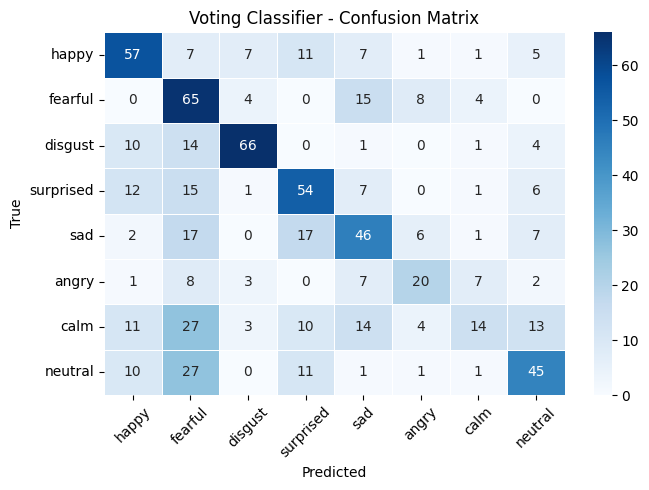

In [73]:
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',linewidths=0.5,
            xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.title("Voting Classifier - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<h2 style="color:purple">Save the model</h3>

In [74]:
import joblib

In [75]:
joblib.dump(rf_grid.best_estimator_, "random_forest_model.pkl")
joblib.dump(svm_grid.best_estimator_, "svm_rbf_model.pkl")
joblib.dump(xgb_grid.best_estimator_, "xgboost_model.pkl")
joblib.dump(voting_clf, "voting_classifier_model.pkl")

['voting_classifier_model.pkl']

In [76]:
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

<h2 style="color:purple">Evaluation on Test Data</h3>

In [77]:
import joblib
model = joblib.load("voting_classifier_model.pkl")

In [108]:
# predict 
y_pred = model.predict(X_test)

In [109]:
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.2f}")

Test Accuracy: 0.39


In [80]:
# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

       angry       0.62      0.41      0.49        96
        calm       0.28      0.50      0.36        96
     disgust       0.46      0.49      0.47        96
     fearful       0.39      0.25      0.31        96
       happy       0.36      0.35      0.36        96
     neutral       0.18      0.10      0.13        48
         sad       0.33      0.16      0.21        96
   surprised       0.44      0.71      0.54        96

    accuracy                           0.39       720
   macro avg       0.38      0.37      0.36       720
weighted avg       0.40      0.39      0.37       720



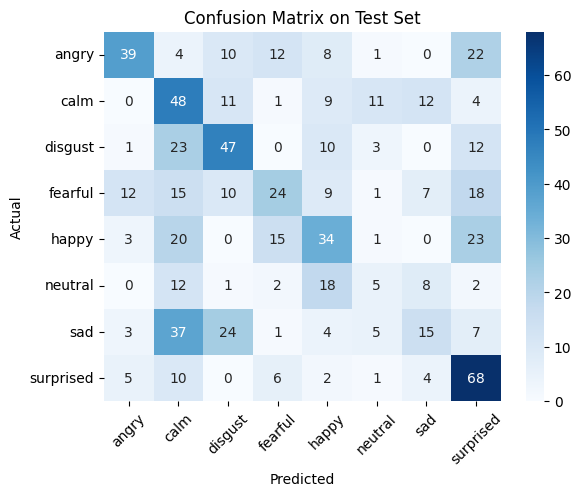

In [81]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.show()

In [82]:

result_df = pd.DataFrame({
    "Actual": y_test, 
    "Predicted": y_pred
})

In [83]:
result_df

,Actual,Predicted
0,surprised,surprised
1,surprised,surprised
2,surprised,surprised
3,angry,surprised
4,angry,surprised
...,...,...
715,fearful,angry
716,fearful,angry
717,angry,disgust
718,angry,disgust


<h3 style="color:purple">Actual vs predicted plot</h3>

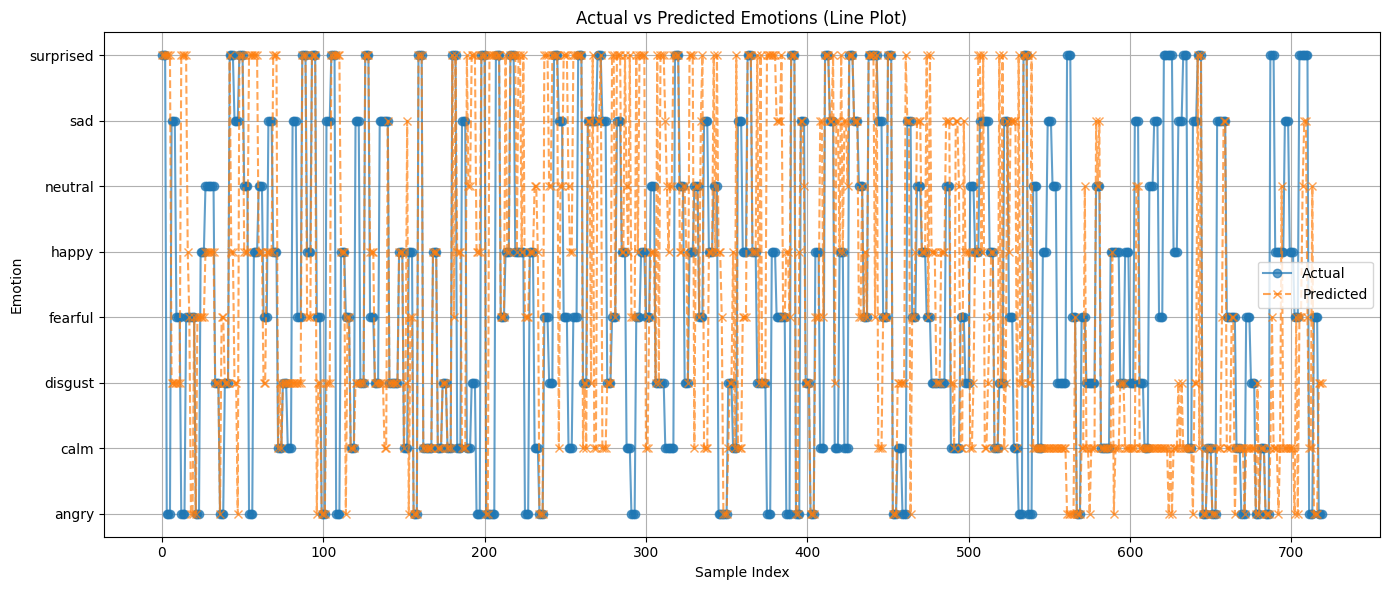

In [84]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Encode emotion
le = LabelEncoder()
le.fit(result_df["Actual"].tolist() + result_df["Predicted"].tolist())

actual_encoded = le.transform(result_df["Actual"])
predicted_encoded = le.transform(result_df["Predicted"])

# Plot
plt.figure(figsize=(14, 6))
plt.plot(actual_encoded, label="Actual", marker='o', linestyle='-', alpha=0.7)
plt.plot(predicted_encoded, label="Predicted", marker='x', linestyle='--', alpha=0.7)

plt.xlabel("Sample Index")
plt.ylabel("Emotion")
plt.title("Actual vs Predicted Emotions (Line Plot)")
plt.yticks(ticks=range(len(le.classes_)), labels=le.classes_)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [85]:
result_df.to_csv("test_result.csv")